![](https://i.loli.net/2018/05/07/5af0400fe9c67.png)

# 机器学习聚类分析实战：鸢尾花(Iris)分类

算法： 
- KMeans 
- GMM

目录： 
- Step1: Iris数据集简介
- Step2: 常用数据可视化方法简介
- Step3: Kmeans聚类实战
- Step4: GMM聚类实战

In [1]:
import pandas as pd
import seaborn as sns    # Seaborn是一个高级的数据可视化包，基于matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

%matplotlib inline

先做一些绘图前的全局属性设置

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)      # 设置绘图图像大小
sns.set(style="white", color_codes=True)      # 

## Step1: Iris数据集简介

In [3]:
iris = pd.DataFrame(load_iris().data)
iris.columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
iris['Species'] = load_iris().target

### 首先探索一下数据集的大体情况，多少个样本，每一个样本多少个特征等

In [5]:
iris.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [6]:
iris.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667,1.000000
std,0.828066,0.433594,1.764420,0.763161,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [7]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null int32
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


In [8]:
iris['Species'].value_counts()

2    50
1    50
0    50
Name: Species, dtype: int64

## Step2: 常用数据可视化方法简介

## <font color=blue> part1. 单变量分析

### 1.箱型图
用作显示一组数据分散情况资料的统计图  
常用作观察离群点（异常点）

![](https://gss1.bdstatic.com/-vo3dSag_xI4khGkpoWK1HF6hhy/baike/c0%3Dbaike80%2C5%2C5%2C80%2C26/sign=28928945f1deb48fef64a98c9176514c/0b55b319ebc4b74596c1a432cdfc1e178a8215b8.jpg)

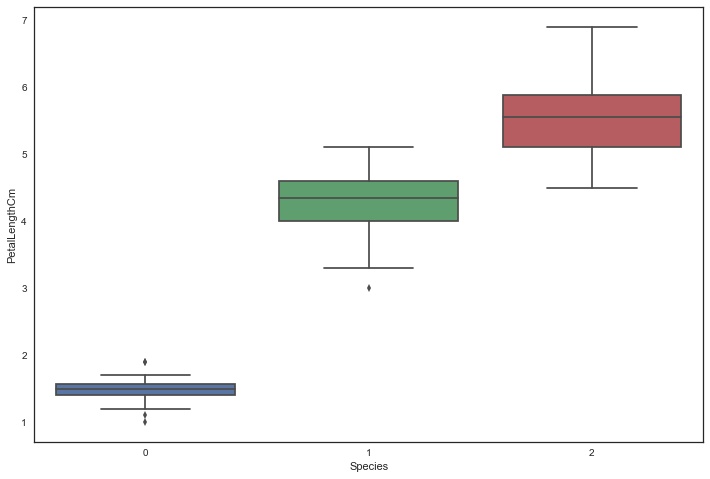

In [9]:
ax = sns.boxplot(x="Species", y="PetalLengthCm", data=iris)

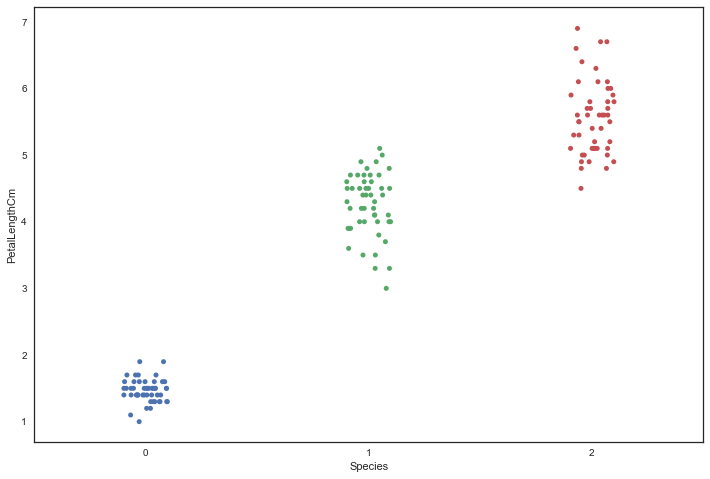

In [14]:
ax = sns.stripplot(x="Species", y="PetalLengthCm", data=iris, jitter=True, edgecolor="black")

下面的操作，将每一个Species所属的点加到对应的位置，加上散点图，  
振动值`jitter=True` 使各个散点分开，要不然会是一条直线  
注意此处要将坐标图用ax先保存起来，这样第二次才会在原来的基础上加上散点图  

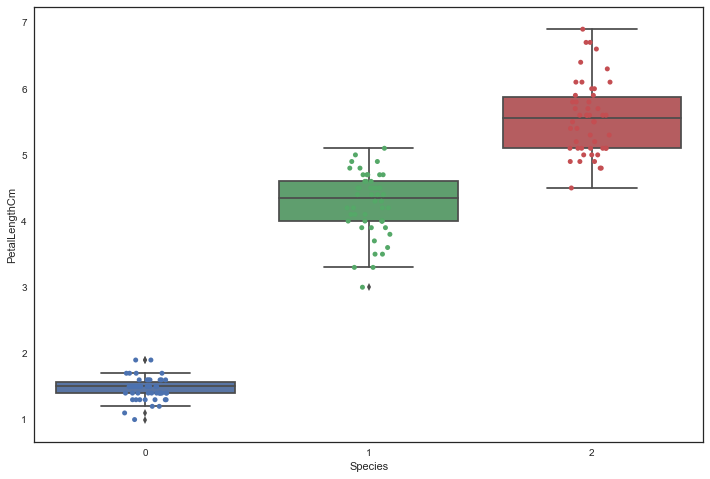

In [15]:
ax = sns.boxplot(x="Species", y="PetalLengthCm", data=iris)
ax = sns.stripplot(x="Species", y="PetalLengthCm", data=iris, jitter=True, edgecolor="gray")

### 2. 小提琴图
violinplot 小提琴图，查看密度分布，结合了前面的两个图，并且进行了简化   
数据越稠密越宽，越稀疏越窄

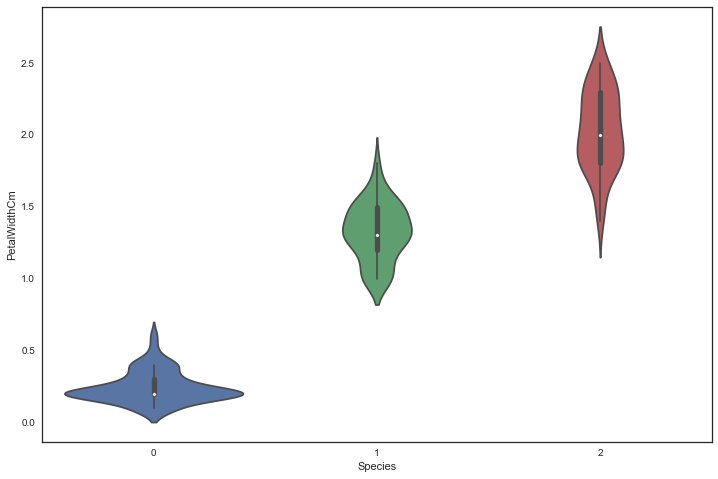

In [18]:
sns.violinplot(x="Species", y="PetalWidthCm", data=iris, size=4)

## <font color=blue> part2. 多变量分析

用 seaborn 的 FacetGrid 函数按照Species花的种类来在散点图上标上不同的颜色，hue英文是色彩的意思。

### 1. 散点图

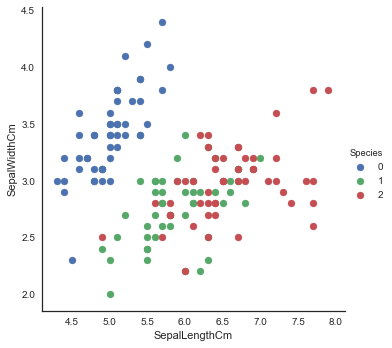

In [21]:
sns.FacetGrid(iris, hue="Species", size=5).map(plt.scatter, "SepalLengthCm", "SepalWidthCm").add_legend()

### 2. pairplot
seaborn绘图的大杀器，一行语句可以描述任意两个变量间的关系

C:\Users\wei.mo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\wei.mo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\wei.mo\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


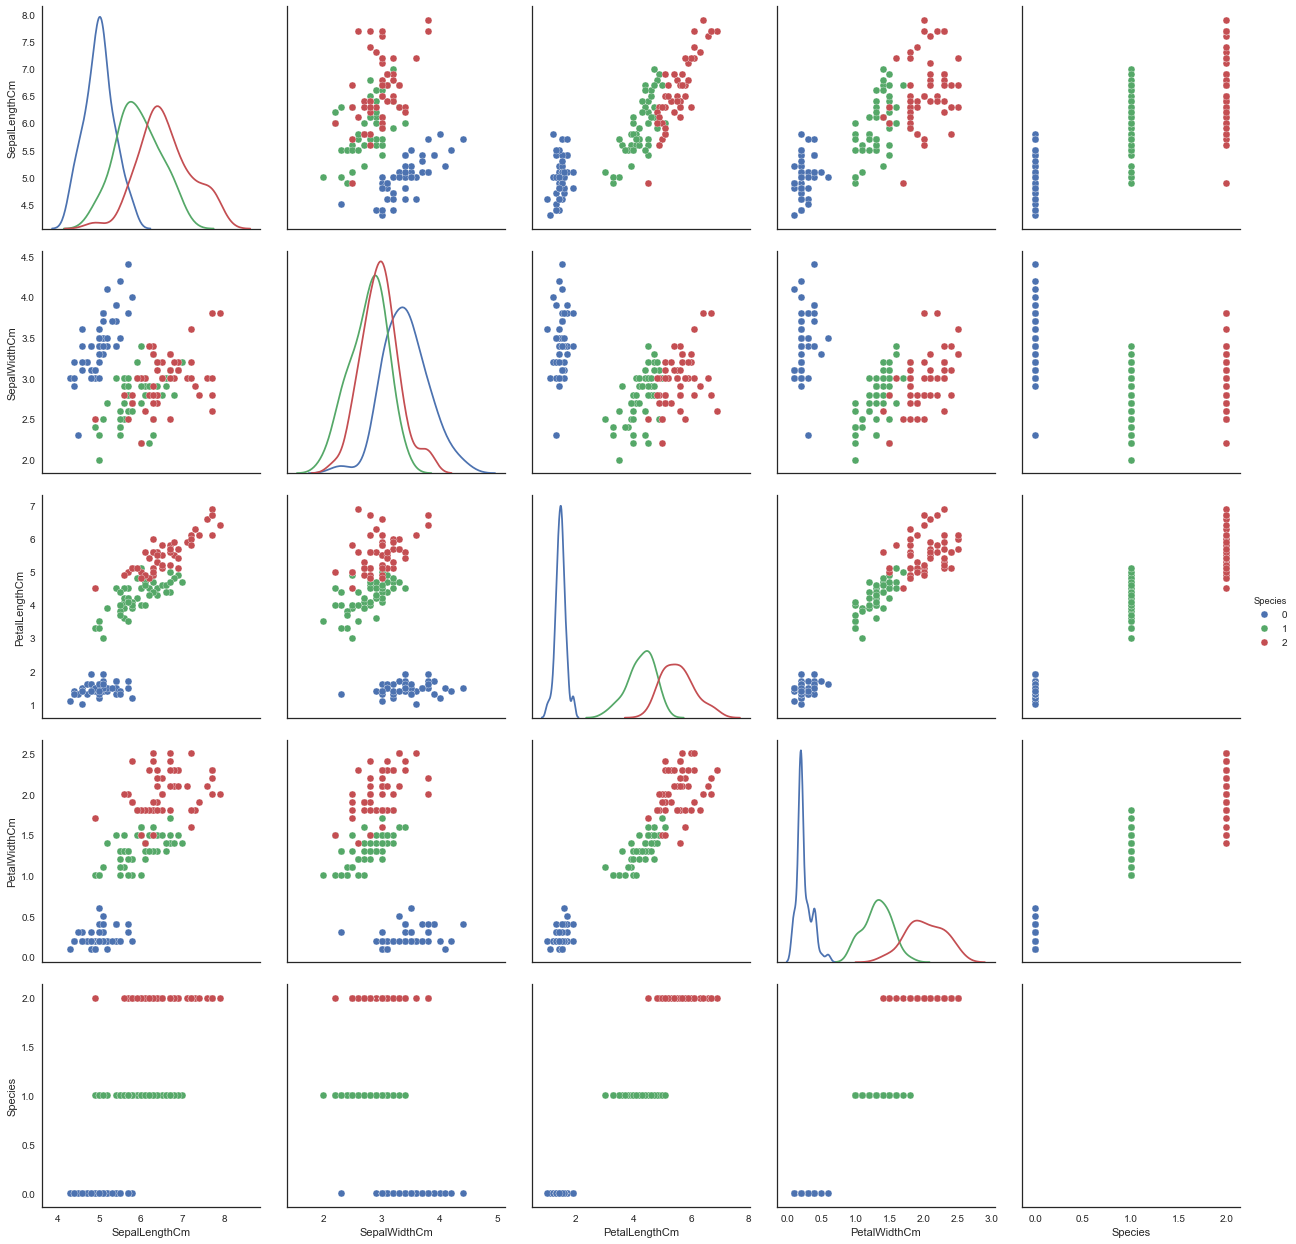

In [22]:
sns.pairplot(iris, hue="Species", size=3.5, diag_kind='kde')

## Step3: Kmeans聚类实战

### 1.数据集划分 

In [23]:
from sklearn.model_selection import train_test_split

y = iris['Species']
X = iris.drop('Species', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

根据上面的分析，选择SepalWidthCm和PetalWidthCm来聚类应该可以得到比较好的效果

### 2. 构建聚类模型并预测

In [24]:
km = KMeans(n_clusters=3)  # 选择聚类的个数
km.fit(X_train[['SepalWidthCm', 'PetalWidthCm']].values)

predict = km.predict(X_test[['SepalWidthCm', 'PetalWidthCm']].values)

- tips: 聚类作为无监督学习的代表，通常是不知道label，也就是所聚类的数目   
这个时候n_clusters应该作为一个参数去搜索

### 3. 结果分析

所预测的Label名称和Species可能不同，所以要进行类别的交换

In [25]:
predict

array([2, 1, 0, 2, 2, 1, 2, 0, 2, 2, 0, 1, 1, 1, 1, 0, 0, 2, 2, 0, 1, 0,
       1, 0, 0, 0, 2, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 1, 0, 0, 2, 1,
       1, 2, 2, 0, 2, 0])

In [27]:
y_test.values

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 2, 2, 1, 2])

In [28]:
def exchange_predict_label(x):
    # 用于交换label的函数，需要自己观察label调整方式
    if x==0:
        return 2
    elif x==1:
        return 0
    else:
        return 1

为了用`Facetgrid`画出聚类后的散点图与真实散点图的对比  
需要构造两个`DataFrame`对象

In [32]:
X_test[['SepalWidthCm', 'PetalWidthCm']].values.shape

(50, 2)

In [36]:
predict.reshape(-1, 1).shape

(50, 1)

In [31]:
predict = np.array([i for i in map(exchange_predict_label, predict)])  # 高大上的列表解析式和map函数

# concate对象必须保证除了caoncate的轴外其他维度相同
X_test_np = np.concatenate([X_test[['SepalWidthCm', 'PetalWidthCm']].values, predict.reshape(-1, 1)], axis=1)
X_test_df = pd.DataFrame(X_test_np, columns=['SepalWidthCm', 'PetalWidthCm', 'Species'])

X_test_true = pd.concat([X_test[['SepalWidthCm', 'PetalWidthCm']], y_test], axis=1)

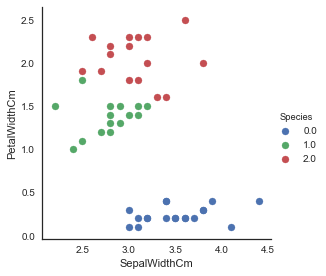

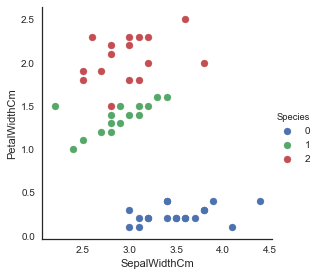

In [38]:
ax = sns.FacetGrid(X_test_df, hue="Species", size=4).map(plt.scatter, 'SepalWidthCm', 'PetalWidthCm').add_legend()
ax = sns.FacetGrid(X_test_true, hue="Species", size=4).map(plt.scatter, 'SepalWidthCm', 'PetalWidthCm').add_legend()

双特征KMeans聚类准确率为：

In [39]:
np.mean(predict == y_test)

0.92

## Step4: GMM聚类实战

### 1. 构建聚类模型并预测

In [40]:
gmm = GaussianMixture(n_components=3, random_state=4)
gmm.fit(X_train[['SepalWidthCm', 'PetalWidthCm']].values)

predict = gmm.predict(X_test[['SepalWidthCm', 'PetalWidthCm']].values)

### 2. 构建聚类模型并预测

In [41]:
X_test_np = np.concatenate([X_test[['SepalWidthCm', 'PetalWidthCm']].values, predict.reshape(-1, 1)], axis=1)
X_test_df = pd.DataFrame(X_test_np, columns=['SepalWidthCm', 'PetalWidthCm', 'Species'])

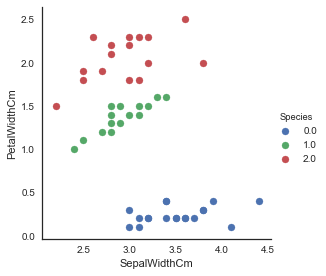

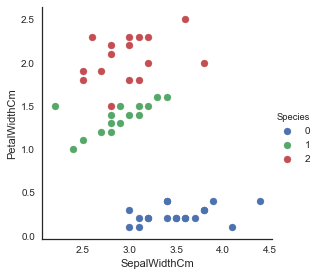

In [42]:
ax = sns.FacetGrid(X_test_df, hue="Species", size=4).map(plt.scatter, 'SepalWidthCm', 'PetalWidthCm').add_legend()
ax = sns.FacetGrid(X_test_true, hue="Species", size=4).map(plt.scatter, 'SepalWidthCm', 'PetalWidthCm').add_legend()

双特征GMM聚类准确率：

In [43]:
np.mean(predict == y_test)

0.96

### 3. 使用全部特征用GMM进行聚类

In [44]:
gmm = GaussianMixture(n_components=3, random_state=1)
gmm.fit(X_train.values)

predict = gmm.predict(X_test.values)

全特征GMM聚类准确率

In [45]:
np.mean(predict == y_test)

0.98

结论：可以看出在本问题中GMM聚类表现出更好的性能  
更多聚类算法对比请点击[链接](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py)

### 作业： 用全特征做Kmeans的聚类，并比较我们选择的双特征做出结果差别